

Notebook by Austin Houston, 2025


This notebook shows how to open a file and plot datasets.

>Note:
> You can combine and arrange these datasets yourself to your liking.

All ususal file-types used in microscopy are handled.  

In [6]:
import numpy as np
import os

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pyTEMlib
import pyTEMlib.file_tools as ft
print('pyTEMlib version', pyTEMlib.__version__)

pyTEMlib version 0.2025.11.4


### You can do it like this for single files:

In [2]:
file_list = ft.FileWidget()


In [ ]:
dataset_collection = file_list.datasets

dataset = file_list.selected_dataset
view = dataset.plot()

### Generate overview map

You can also read a file inline

In [24]:
folder_path = '/Volumes/Extreme SSD/STEM_data/2025/20251031/PdSe2_TrackBlast_EELS/'
files = os.listdir(folder_path)
files = [f for f in files if '.emd' in f]
files = [f for f in files if not f.startswith('.')]
files.sort()
    
# at this point, filter them however you like
# for instance, I'm going to only keep files with 'HAADF' in the name
files =[f for f in files if 'HAADF' in f]

In [26]:
indicies = []
shapes = []
pixel_sizes = []
stage_pos =[]
images = []

for file in files:
    index = file.split(' ')[0]
    dset = ft.open_file(folder_path + file)
    
    for key in dset.keys():
        if dset[key].title =='HAADF':        
            # scrape metadata
            shape = dset[key].shape
            pixel_size = dset[key].x[1] # in nm
            x = float(dset[key].original_metadata['Stage']['Position']['x'])
            y = float(dset[key].original_metadata['Stage']['Position']['y'])

            # image
            if len(shape) == 2:
                images.append(np.array(dset[key]))
            elif len(shape) ==3:
                images.append(np.array(dset[key][0]))

            # append
            indicies.append(index)
            shapes.append(shape)
            pixel_sizes.append(pixel_size)
            stage_pos.append(np.array([x,y]))


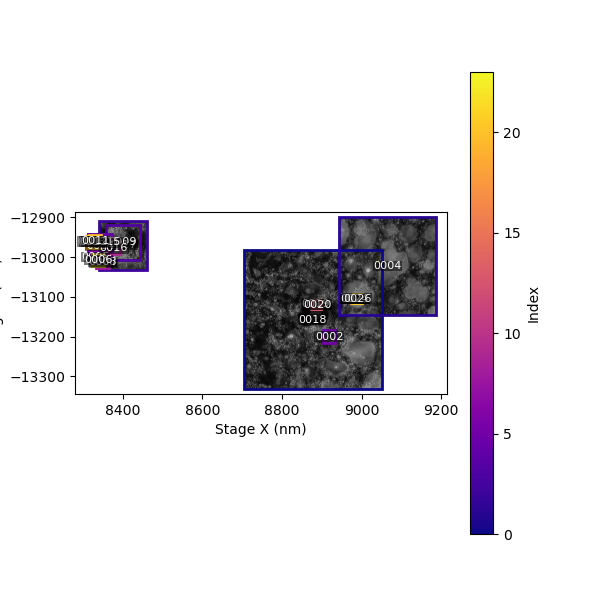

In [36]:
# Sort by FOV (descending)
fovs = np.array(pixel_sizes) * np.array([s[0] for s in shapes])
order = np.argsort(fovs)[::-1]
indicies, shapes, pixel_sizes, stage_pos, images = (
    [arr[i] for i in order] for arr in (indicies, shapes, pixel_sizes, stage_pos, images))

# Plot setup
fig, ax = plt.subplots(figsize=(6,6))
norm = Normalize(0, len(images))
cmap = plt.colormaps['plasma']

bounds = []
for i, (idx, shape, px, pos, img) in enumerate(
    zip(indicies, shapes, pixel_sizes, stage_pos, images)):

    x, y = pos * 1e9
    w, h = px * shape[-1], px * shape[-2]

    xmin, xmax = x - w / 2, x + w / 2
    ymin, ymax = y - h / 2, y + h / 2
    bounds.append((xmin, xmax, ymin, ymax))

    ax.imshow(img,extent=[xmin, xmax, ymin, ymax],cmap='gray')

    patch = patches.Rectangle((xmin, ymin), w, h,fill=False,lw=2,edgecolor=cmap(norm(i)))
    ax.add_patch(patch)

    ax.text(x, y, str(idx),fontsize=8, color='white', ha='center', va='center',
        bbox=dict(fc='black', ec='none', alpha=0.5, pad=0.2))

# Axis limits
bounds = np.array(bounds)
xmin, xmax = bounds[:, [0, 1]].min(), bounds[:, [0, 1]].max()
ymin, ymax = bounds[:, [2, 3]].min(), bounds[:, [2, 3]].max()

# Pad
pad = 0.03
ax.set_xlim(xmin - pad * (xmax - xmin), xmax + pad * (xmax - xmin))
ax.set_ylim(ymin - pad * (ymax - ymin), ymax + pad * (ymax - ymin))

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Index')
ax.set(xlabel='Stage X (nm)', ylabel='Stage Y (nm)');
